# Student activity analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from mlxtend.plotting import category_scatter, plot_decision_regions
%config IPCompleter.greedy = True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9,6)})  # настройка, которая добавит дефолтный размер графика

Практическим проектом курса будет анализ активности студентов онлайн курса Введение в анализ данных в R, спасибо команде stepik, что предоставили анонимизированные данные.

## Описание данных:

### events_train.csv - данные о действиях, которые совершают студенты со стэпами

step_id - id стэпа

user_id - анонимизированный id юзера

timestamp - время наступления события в формате unix date

action - событие, возможные значения: 

    discovered - пользователь перешел на стэп

    viewed - просмотр шага,

    started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага

    passed - удачное решение практического шага

### submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа

timestamp - время отправки решения в формате unix date

submission_status - статус решения

user_id - анонимизированный id юзера

In [4]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [8]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [9]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', \
                               compression ='zip')

In [10]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


##### Unix-time - Определяется как количество секунд, прошедших с полуночи (00:00:00 UTC) 1 января 1970 года (четверг); этот момент называют «эпохой Unix»

timestamp - формат Unix-time

Самый первый шаг - проверить насколько валидные данные.

In [11]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [12]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [14]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [15]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [16]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [17]:
events_data['day'] = events_data.date.dt.date
submissions_data['day'] = submissions_data.date.dt.date
events_data.head(3)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15


Посмотрим на графике как менялось количество уникальных пользователей курса за весь период данных. 

<Axes: xlabel='day'>

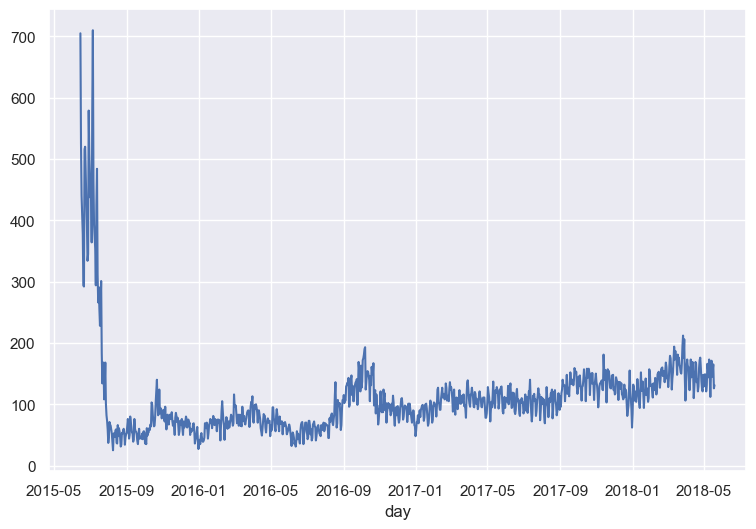

In [18]:
events_data.groupby('day') \
    .user_id.nunique().plot()

Вначале видим первый этап жизни продукта - большой всплеск пользователей, записавшихся на курс. 

Второй этап - более плавный рост пользователей за период с 2015 - 2018гг.

Посчитаем число степов, которые решил каждый пользователей.

<Axes: >

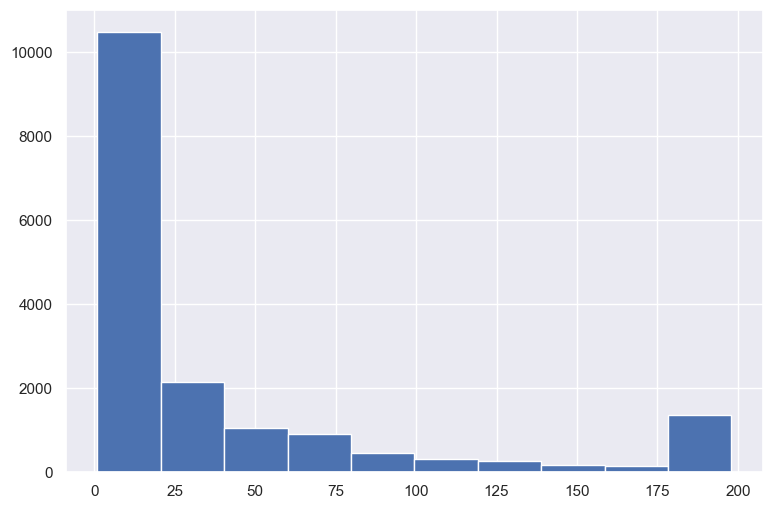

In [19]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_step'}).passed_step.hist()

Но! Мы потеряли пользователей, у которых событий passed_step = 0

In [20]:
users_events_data=events_data.pivot_table(index = 'user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<Axes: >

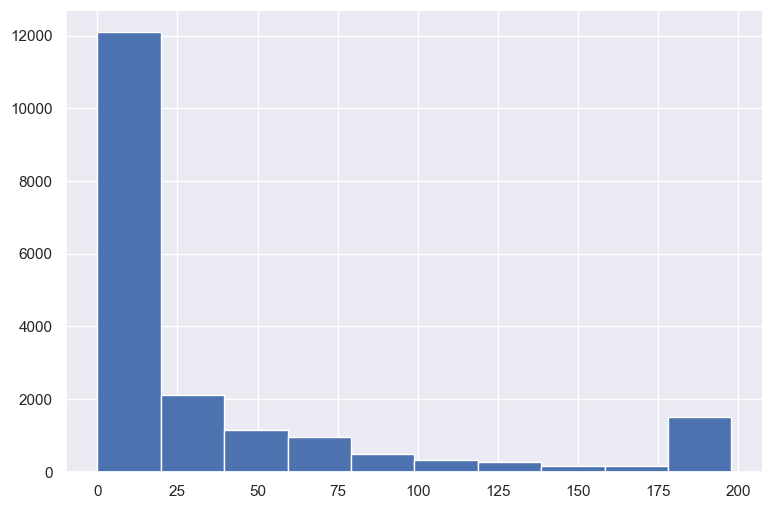

In [21]:
users_events_data.discovered.hist()

Теперь мы не потеряли данные, которыe, возможно, будут важны для дальнейшей аналитики.

Посчитаем сколько данных, имеющих статус "correct" submit.

In [22]:
users_scores = submissions_data.pivot_table(index = 'user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()

In [23]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Чтобы выделить пользователей, которые бросили курс нам необходимо понять какой промежуток времени (отсутствия на курсе) брать за основу для фильтрации. Посмотрим какие промежутки между сабмитами присутствуют в наших данных по каждому пользователю и посчитаем средние статистики, чтобы принять решение, основываяся на подкрепленных статистических данных.

In [24]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

# удалим дубликаты из 'user_id', 'day' 
# сгруппируем по польз. и сохраним timestamp в список  
# применим к списку функцию np.diff - посчитаем разницу в датах  


Для каждого пользователя отобрали его уникальные дни, в которые он был онлайн на курсе и сохранили их в список.

In [25]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))  

In [26]:
#получим разницу в днях между заходами на курс по пользователям
gap_data = gap_data / (24 * 60 * 60)   

<Axes: >

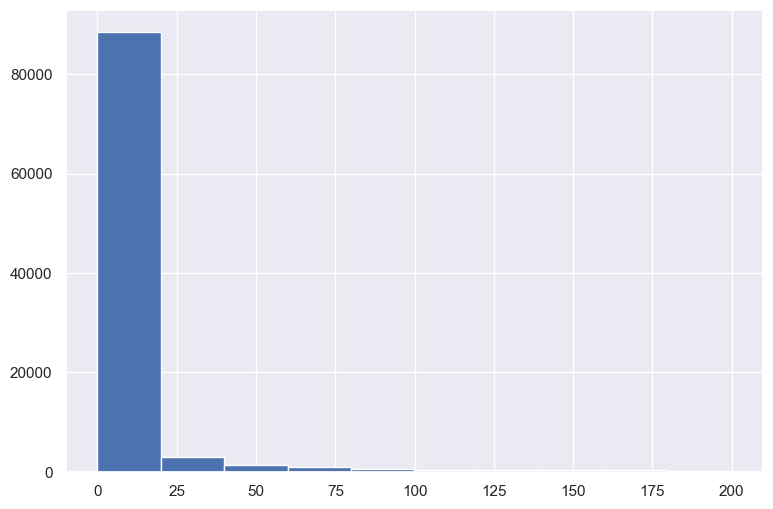

In [27]:
# посмотрим эти данные (без выбросов) на графике
gap_data[gap_data < 200].hist()   

Большая часть разниц между заходами пользователей укладывается в диапазон от 0 до 25 дней.

In [28]:
gap_data.quantile(0.95)

59.760440972222156

Только 5% пользователей возвращается на курс после перерыва в 2 месяца.

In [29]:
gap_data.quantile(0.90)

18.325995370370403

90% пользователей укладываются в 18 дневные перерывы. Возьмем усредненную оценку между 95 и 90 процентилями - 30 дней (календарный месяц). Это время отсутствия на курсе студента, превышая которое можно отнести студента к категории "дропнувшихся".
Таймстемп нашего порогового значения в месяц:

In [30]:
drop_out_threshold = 30 * 24 * 60 * 60
drop_out_threshold

2592000

###### Задача.
За каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

In [31]:
submissions_data[submissions_data.submission_status == 'correct'] \
    .groupby('user_id', as_index=False)['step_id'] \
    .count() \
    .sort_values(by='step_id', ascending=False) \
    .rename(columns={'step_id': 'correct_sub_count'}) \
    .head(3)

,user_id,correct_sub_count
433,1046,421
2062,5552,186
6323,17135,168


##### ___________________________________________________________________________________________

In [32]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [33]:
events_data.tail(1)

,step_id,timestamp,action,user_id,date,day
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Последняя дата на которую были выгружены данные 2018-05-19 (timestamp = 1526772811).

In [34]:
# Финальный день
now = 1526772811
# Пороговое значение для 'дропнувшихся' студентов в 30 дней
drop_out_threshold

2592000

In [35]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Соединим 2 Датафрейма users_data и users_scores с помощью метода merge().

In [36]:
# для того, чтобы не потерять юзеров, у которых не было ни 1 попытки в табл. users_scores
# будем мерджить 'outer'. Т.к. по умолчанию 'inner' - только пересечения.
users_data = users_data.merge(users_scores, on='user_id', how='outer')

Не забываем убрать head (), когда записываем результаты в переменную.

In [37]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [38]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1


Посчитаем число уникальных дней для каждого юзера и примерджим к Датафрейму users_data.

In [39]:
# Метод .to_frame() преобразует из Серии в Датафрейм
# Метод .reset_index() избавляется от мультииндексности
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [40]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1


In [41]:
# Сомопроверка - не потерялись ли юзеры?
users_data.user_id.nunique()

19234

In [42]:
events_data.user_id.nunique()

19234

Юзер успешно прошел курс, если набрал более 170 баллов.

In [43]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False


In [44]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,8515,8515,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [45]:
# доля прошедших курс
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

Т.о была проведена предобработка данных: проверка на валидность, проверка на здравую логику, проверили количество наблюдений, перевели данные в аггрегированную таблицу для дальнейших проверок гипотез. Можно вытащить разные стратегии прохождения курсов.

Однако, Датафрейм содержит данные по пользователям, которые находятся в финальной стадии или уже дропнувшийся, на этих пользователей мы уже никак повлиять не можем
. Необходимо предсказывать дропнется/не дропнется пользователь с курса как можно раньше, чтоб каким-то образом смотивировать его на дальнейшее обучение. Поэтому нужны данные не за весь период прохождения курса, а за начальную стадию, например первую неделю, чтобы проверить интересную идею "Правда ли что по поведению пользователя в первую неделю курса уже можно предсказать закончит он его успешно или нет?". Т.е. не дать пользователю перейти в класс дропнувшихся.

##### ______________________________________________________________________________________________________

## Часть 2.

user_id - идентификатор юзера

last_timestamp - время наступления последнего события в формате unix date

is_gone_user - признак ушедшего с курса юзера

correct - кол-во верных решений

wrong - кол-во попыток (неверных) решений

discovered - кол-во событий "пользователь перешел на степ"

passed - кол-во событий "удачное решение практического шага"

started_attempt - кол-во событий "начало попытки решить шаг"

viewed - кол-во событий "просмотр шага"

day - кол-во дней проведенных на курсе

passed_course - признак завершения юзером курса

Задача: отобрать те наблюдения, которые мы будем использовать для обучения, events data, т.е. события которые происходили с ним в течении первых 3 дней.

In [46]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [47]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [48]:
users_data = users_data.merge(user_min_time, how='outer')

In [49]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False,1521634660


In [50]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

Вместо использования цикла for функция map() дает возможность применить функцию к каждому элементу итерируемого объекта. Это повышает производительность

In [51]:
# посчитаем порог в 3 дня
learning_time_treshold = 3 * 24 * 60 * 60  
learning_time_treshold 

259200

In [52]:
# для каждого юзера посчитаем его 3х дневную дату (первые дни) и склеим это в строку с айди
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold) \
    .map(str)

In [53]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [54]:
# Смерджим, outer - чтобы не потерять пропущенные значения
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')  

In [55]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [56]:
# Теперь сравним строки
# Отфильтруем данные по каждому пользователю, чтобы user_time вписывался в наши сроки
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [57]:
events_data_train.head(3)

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048


Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей. 

In [58]:
# Сначала отфильтруем все неверные шаги всех пользователей
submissions_data_wrong = submissions_data[(submissions_data.submission_status == 'wrong')]
submissions_data_wrong

,step_id,timestamp,submission_status,user_id,date,day
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
15,32031,1434363465,wrong,15853,2015-06-15 10:17:45,2015-06-15
33,32795,1434520465,wrong,15853,2015-06-17 05:54:25,2015-06-17
38,32812,1434346160,wrong,15853,2015-06-15 05:29:20,2015-06-15
...,...,...,...,...,...,...
509096,120745,1500154509,wrong,3310,2017-07-15 21:35:09,2017-07-15
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [61]:
# Для каждого пользователя найдем его последний по времени шаг
submissions_data_last = submissions_data_wrong.groupby(['user_id']) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})
submissions_data_last.head()

,last_timestamp
user_id,
3,1444568755
5,1499859715
8,1480604128
14,1436368601
16,1513104380


In [62]:
# Смерджим эти две таблицы
submissions_data_last = submissions_data_last.merge(submissions_data_wrong[['step_id', 'user_id', 'submission_status']], \
                                                    on='user_id', how='outer')
submissions_data_last.head()

,user_id,last_timestamp,step_id,submission_status
0,3,1444568755,31977,wrong
1,3,1444568755,31977,wrong
2,3,1444568755,31977,wrong
3,3,1444568755,31983,wrong
4,3,1444568755,31983,wrong


In [64]:
# Сгруппируем по степу, посчитаем количество юзеров по каждому степу и отсортируем по убыванию.
submissions_data_last = submissions_data_wrong.groupby(['step_id'], as_index=False) \
    .agg({'user_id': 'count'}) \
    .sort_values(by=['user_id'], ascending=False) \
    .rename(columns={'user_id': 'count_user_id'})
submissions_data_last.head()

,step_id,count_user_id
4,31978,16084
11,32031,13373
19,32202,13002
44,33481,10300
12,32075,10003


Ответ: 31978 - степ, на котором большая часть студентов 'сдалась'.

###### __________________________________________________________________________________________________

##### Pandas: как получить первую строку каждой группы: 
**df.groupby('column_name'). nth ( 0 )**

In [67]:
# Проверим наши данные (мы установили порог в 3 дня, т.е. должно быть максимальное кол-во уникальных дней не более 4)
events_data_train.groupby('user_id').day.nunique().max()

4

In [68]:
# Проделаем все то же самое для ДатаСета submissions_data
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [69]:
# Возьмем число уникальных дней, которые есть в сабмитах
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

In [70]:
# Посчитаем сколько степов человек попытался решить за первые 3 дня
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'step_tried'})

In [71]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [72]:
X.shape

(8913, 3)

In [73]:
# Добавим по каждому пользователю кол-во правильных/неправильных сабмитов за первые 2 дня
X = X.merge(submissions_data_train.pivot_table(index = 'user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index())

In [74]:
# Добавим еще одну переменную - доля правильных ответов
X['correct_ratio'] = round(X.correct / (X.correct + X.wrong), 2)

In [77]:
X.head(2)

,user_id,days,step_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.0
1,3,1,4,4,4,0.5


In [78]:
# Добавим сколько было суммарно просмотренных степов
X = X.merge(events_data_train.pivot_table(index = 'user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [79]:
# Заполним пропуски нулем
X = X.fillna(0)

In [80]:
# Добавим информацию закончил ли пользователь курс и дропнулся он или нет 
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [83]:
# Отфильтруем данные для X (нам нужны кто уже либо прошел курс либо курс не прошел, но бросил его) Знак тильда - отрицание
X = X[~((X.is_gone_user == False) & (X.passed_course ==False))]

In [84]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [85]:
y = X.passed_course.map(int)

In [86]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [87]:
# Сделаем в качестве индекса - user_id
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [88]:
X.isnull().sum()

days             0
step_tried       0
correct          0
wrong            0
correct_ratio    0
viewed           0
dtype: int64

###### ______________________________________________________________________________________________________________

## Обучим пройденные в курсе модели, посчитаем показатели качества и сравним модели.

### Логистическая Регрессия

Разобьем датасет на обучающую и тестовую выборки.

In [89]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [90]:
log_model = LogisticRegression()

In [91]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [92]:
y_pred = log_model.predict(X_test)

Посчитаем показатели качества:

Accuracy - доля объектов, для которых мы правильно предсказали класс. Не учитывает дисбаланс классов!

Precision - доля верно класс-х объектов среди всех выбранных объектов

Recall - доля верно класс-х объектов к общему числу эл-в этого класса

F1-score - среднее гармоническое точности и полноты

In [93]:
print('log_model')
print(f'Accuracy = {round(accuracy_score(y_test, y_pred), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred), 3)}')
print(f'Recall = {round(recall_score(y_test, y_pred), 3)}')
print(f'F1-score = {round(f1_score(y_test, y_pred), 3)}')

log_model
Accuracy = 0.93
Precision = 0.547
Recall = 0.168
F1-score = 0.257


Видим, что Recall очень низкий - значит наша модель часто совершает ложно-отрицательные ошибки, т.е. не относит студентов к классу продолжающих обучение, хотя должна была.

Теперь попробуем подобрать параметры с помощью GridSearchCV

In [94]:
log_model_2 = LogisticRegressionCV()

In [95]:
parametrs = {'multi_class': ['auto', 'ovr', 'multinomial'], 'cv': range(2,7)}

In [96]:
grid_search_log_model_2 = GridSearchCV(log_model_2, parametrs)   

In [97]:
grid_search_log_model_2.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegressionCV(),
             param_grid={'cv': range(2, 7),
                         'multi_class': ['auto', 'ovr', 'multinomial']})

In [98]:
grid_search_log_model_2.best_params_

{'cv': 5, 'multi_class': 'multinomial'}

In [99]:
grid_search_log_model_2 = grid_search_log_model_2.best_estimator_

In [100]:
y_pred = grid_search_log_model_2.predict(X_test)

In [101]:
print('grid_search_log_model_2')
print(f'Accuracy = {round(accuracy_score(y_test, y_pred), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred), 3)}')
print(f'Recall = {round(recall_score(y_test, y_pred), 3)}')
print(f'F1-score = {round(f1_score(y_test, y_pred), 3)}')

grid_search_log_model_2
Accuracy = 0.93
Precision = 0.552
Recall = 0.168
F1-score = 0.258


##### _______________________________________________________________________________________________

### Решающее Дерево

In [102]:
clf = tree.DecisionTreeClassifier()

In [103]:
# Создадим словарь с параметрами, которые хотим "потюнить"
parametrs = {'criterion': ['gini', 'entropy'], 
             'max_depth': range(1, 20), 
             'max_leaf_nodes':range(3,9), 
             'min_samples_leaf': range(1,4),
             'min_samples_split':range(2,5)}

In [104]:
# В GridSearchCV передадим наш пустой классификатор и словарик с параметрами, 
# cv=5 фолдов для кросс-валидации
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [105]:
# Обучаем модель на основе GridSearchCV
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'max_leaf_nodes': range(3, 9),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 5)})

In [106]:
grid_search_cv_clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_leaf_nodes': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [107]:
best_clf = grid_search_cv_clf.best_estimator_

In [108]:
y_pred = best_clf.predict(X_test)

In [109]:
print('grid_search_cv_clf')
print(f'Accuracy = {round(accuracy_score(y_test, y_pred), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred), 3)}')
print(f'Recall = {round(recall_score(y_test, y_pred), 3)}')
print(f'F1-score = {round(f1_score(y_test, y_pred), 3)}')

grid_search_cv_clf
Accuracy = 0.93
Precision = 0.496
Recall = 0.173
F1-score = 0.257


##### _________________________________________________________________________________________________

### Метод ближайших соседей

In [158]:
clf_knn = KNeighborsClassifier()

In [159]:
parameters = {'n_neighbors': range(10,20), 
              'leaf_size':range(1,7)} 

In [160]:
grid_search_cv_clf = GridSearchCV(clf_knn, parameters, cv=5)

In [161]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': range(1, 7),
                         'n_neighbors': range(10, 20)})

In [162]:
grid_search_cv_clf.best_params_

{'leaf_size': 2, 'n_neighbors': 17}

In [163]:
best_knn = grid_search_cv_clf.best_estimator_

In [164]:
y_pred = best_knn.predict(X_test)

In [165]:
print('clf_knn')
print(f'Accuracy = {round(accuracy_score(y_test, y_pred), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred), 3)}')
print(f'Recall = {round(recall_score(y_test, y_pred), 3)}')
print(f'F1-score = {round(f1_score(y_test, y_pred), 3)}')

clf_knn
Accuracy = 0.93
Precision = 0.451
Recall = 0.134
F1-score = 0.206


##### ________________________________________________________________________________________________________

### Итоги. Сравнение моделей.

Все использованные модели (Логистическая, Дерево Решений, Метод ближайших соседей) оказались довольно слабыми, даже с учетом подбора параметров с помощью GridSearchCV. Показатель Accuracy высокий, однако, на наших данных неверно опираться на него, потому что в наших данных присутствует дисбаланс классов.

Посмотрим насколько сильный дисбаланс классов:

In [108]:
y.loc[ lambda x : x == 0].count()

16897

In [109]:
y.loc[ lambda x : x == 1].count()

1425

Decision Regions Функция для построения областей принятия решений классификаторов в 1 или 2 измерениях.

In [167]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

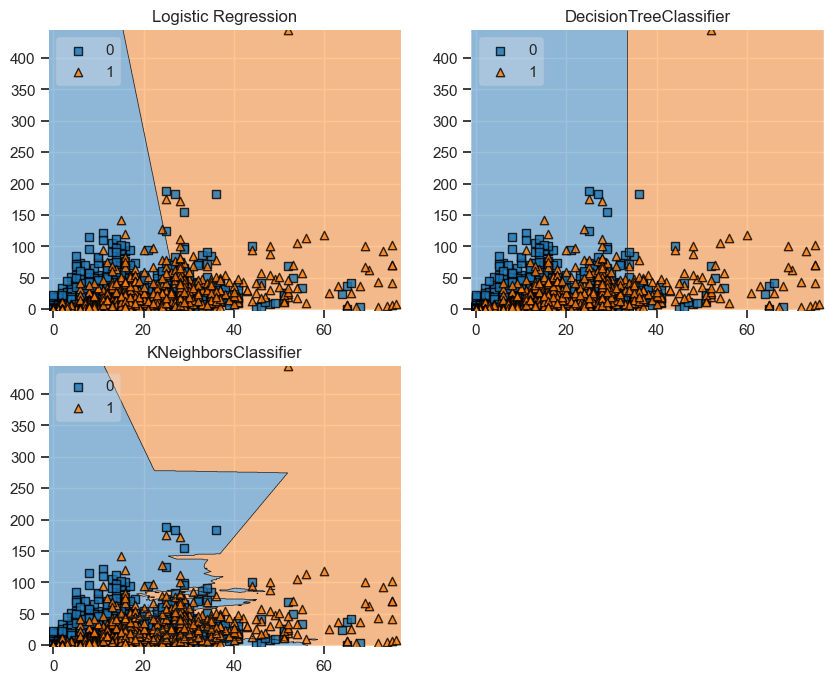

In [171]:
X2 = X.iloc[:,2:4]
X2 = X2.to_numpy()
y2 = y.to_numpy()

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression', 'DecisionTreeClassifier', 'KNeighborsClassifier']

for clf, lab, grd in zip([grid_search_log_model_2, best_clf, best_knn],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X2, y2)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X2, y=y2,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()

Если нарисовать графически результаты классифакаторов (но только по 2м фичам, т.к. пространство двумерное), используя Decision Regions, увидим насколько графики хорошо объясняют довольно низкий Recall, F1-score - наши данные пока невозможно классифицировать хорошо. Возможно нужно добавить другие признаки или использовать другие модели.

##### ______________________________________________________________________________________________________

### 3 часть

Данная часть курса находится в следующем файле "Contest". 